In [14]:
from neural_network import *

from matplotlib import pyplot as plt

import numpy as np
import pandas as pd

from scipy.stats import norm

In [15]:
input_size1 = 5
output_size1 = 2
input_size2 = 3
output_size2 = 2

filename = 'model.pt'

NN = Neural_network(input_size1,output_size1,input_size2,output_size2)

NN.load(filename)
NN.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
pars_base = {'c':8.3, 'phi':31.6, 'gamma':15, 'c_cov':30, 'phi_cov':20, 'gamma_cov':7, 'H':10}
costs_base = {'operation':5, 'escavation':13, 'failure1':20, 'failure2':10000, 'expansion':1.2}

mult_range = np.linspace(0.5,1.5,151)

In [17]:
def get_optimum(pars,costs,deltaHV=0.0001):

    HVs = np.arange(0.2,5,deltaHV)

    n_cases = len(HVs)

    data_in = np.tile(np.array([pars['c'],pars['phi'],pars['gamma'],0,pars['H'],pars['c_cov'],pars['phi_cov'],pars['gamma_cov']]),(n_cases,1))
    data_in[:,3] = HVs

    df = NN.run_model(data_in,costs=costs)

    M = df.to_numpy()

    ind_min = np.argmin(M[:,15])

    HV = M[ind_min,3]
    FS = M[ind_min,9]
    beta = M[ind_min,11]
    PF = M[ind_min,12]
    c_init = M[ind_min,13]
    c_fail = M[ind_min,14]
    c_total = M[ind_min,15]

    return HV, FS, PF, c_init, c_fail, c_total, beta


In [18]:
def sweep_var(var,val_range,pars_base,costs_base):
    #pars_base = {'c':8.3, 'phi':31.6, 'gamma':15, 'c_cov':30, 'phi_cov':20, 'gamma_cov':7, 'H':10}
    #costs_base = {'operation':5, 'escavation':13, 'failure1':20, 'failure2':10000, 'expansion':1.2}

    pars = pars_base.copy()
    costs = costs_base.copy()

    n_cases = len(val_range)
    HV = np.zeros(n_cases); FS = np.zeros(n_cases); PF = np.zeros(n_cases); beta = np.zeros(n_cases)
    c_init = np.zeros(n_cases); c_fail = np.zeros(n_cases); c_total = np.zeros(n_cases)

    for i, val in enumerate(val_range):
        if var.startswith(('c_')):
            costs[var[2:]]=val
        else:
            pars[var]=val

        HV[i], FS[i], PF[i], c_init[i], c_fail[i], c_total[i], beta[i] = get_optimum(pars,costs)

    return HV, FS, PF, c_init, c_fail, c_total, beta

In [19]:
var = 'phi'

ranges = {'c': [5, 30],
            'phi': [20, 35],
            'gamma': [15, 20],
            'c_cov': [10, 50],
            'phi_cov': [10, 30],
            'gamma_cov': [3, 11]}

val_range = np.linspace(ranges[var][0],ranges[var][1],151)


HV, FS, PF, c_init, c_fail, c_total, beta = sweep_var(var,val_range,pars_base,costs_base)

In [20]:
pars_base

{'c': 8.3,
 'phi': 31.6,
 'gamma': 15,
 'c_cov': 30,
 'phi_cov': 20,
 'gamma_cov': 7,
 'H': 10}

Text(0, 0.5, 'Costs')

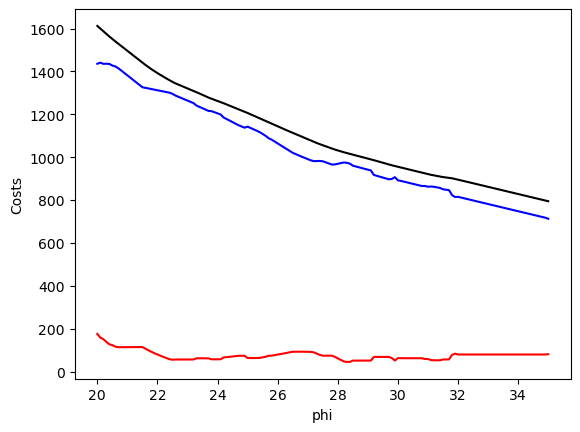

In [21]:
plt.plot(val_range,c_init,'b')
plt.plot(val_range,c_fail,'r')
plt.plot(val_range,c_total,'k')

plt.xlabel(var)
plt.ylabel('Costs')


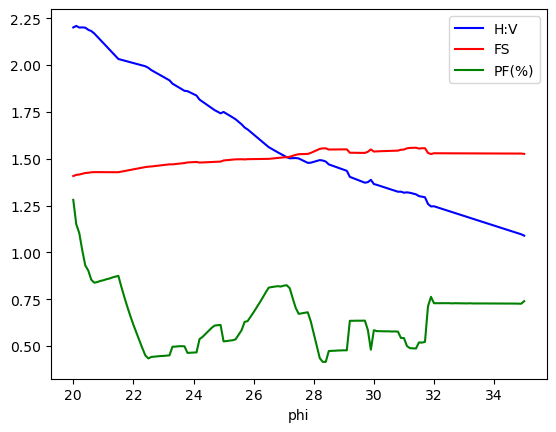

In [22]:
plt.plot(val_range,HV,'b',label='H:V')
plt.plot(val_range,FS,'r', label='FS')
plt.plot(val_range,100*PF,'g',label='PF(%)')

plt.xlabel(var)
plt.legend()

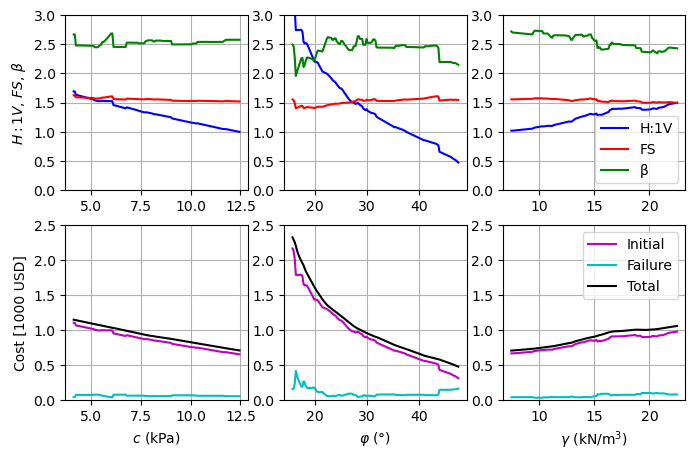

In [23]:
vars = ['c','phi','gamma']
var_names = ['$c$ (kPa)', '$φ$ (°)', '$γ$ (kN/m$^3$)']

plt.figure(figsize=(8, 5))

for i in range(0,3):

    var = vars[i]

    if var.startswith(('c_')):
        val_range=costs_base[var[2:]] * mult_range
    else:
        val_range = pars_base[var] * mult_range

    HV, FS, PF, c_init, c_fail, c_total, beta = sweep_var(var,val_range,pars_base,costs_base)

    plt.subplot(2,3,i+1)
    plt.plot(val_range,HV,'b',label='H:1V')
    plt.plot(val_range,FS,'r', label='FS')
    plt.plot(val_range,beta,'g',label='β')

    if i == 2:
        plt.legend()

    plt.grid(True)

    if i == 0:
        plt.ylabel('$H:1V$, $FS$, $β$')
    plt.ylim((0,3))

    plt.subplot(2,3,i+4)
    plt.plot(val_range,c_init/1000,'m',label='Initial')
    plt.plot(val_range,c_fail/1000,'c',label='Failure')
    plt.plot(val_range,c_total/1000,'k',label='Total')

    plt.xlabel(var_names[i])
    if i == 2:
        plt.legend()

    plt.grid(True)

    if i == 0:
        plt.ylabel('Cost [1000 USD]')
    plt.ylim((0,2.5))

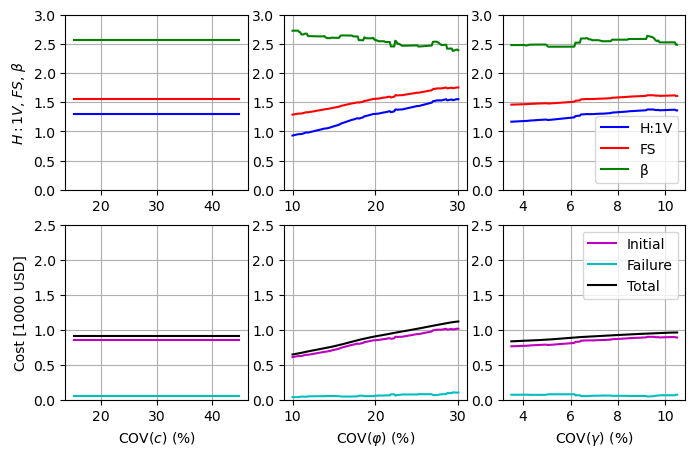

In [24]:
vars = ['c_cov','phi_cov','gamma_cov']
var_names = ['COV($c$) (%)', 'COV($φ$) (%)', 'COV($γ$) (%)']

plt.figure(figsize=(8, 5))

for i in range(0,3):

    var = vars[i]

    if var.startswith(('c_')) and not var == 'c_cov':
        val_range=costs_base[var[2:]] * mult_range
    else:
        val_range = pars_base[var] * mult_range

    HV, FS, PF, c_init, c_fail, c_total, beta = sweep_var(var,val_range,pars_base,costs_base)

    plt.subplot(2,3,i+1)
    plt.plot(val_range,HV,'b',label='H:1V')
    plt.plot(val_range,FS,'r', label='FS')
    plt.plot(val_range,beta,'g',label='β')

    if i == 2:
        plt.legend()

    plt.grid(True)

    if i == 0:
        plt.ylabel('$H:1V$, $FS$, $β$')
    plt.ylim((0,3))

    plt.subplot(2,3,i+4)
    plt.plot(val_range,c_init/1000,'m',label='Initial')
    plt.plot(val_range,c_fail/1000,'c',label='Failure')
    plt.plot(val_range,c_total/1000,'k',label='Total')

    plt.xlabel(var_names[i])
    if i == 2:
        plt.legend()

    plt.grid(True)

    if i == 0:
        plt.ylabel('Cost [1000 USD]')
    plt.ylim((0,2.5))